# License 
***
Copyright (C) 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

***
# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

import matplotlib as plt
%matplotlib inline

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpl6pba3qb
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpl6pba3qb/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpl6pba3qb/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  --------------------------------
H2O cluster uptime:         01 secs
H2O cluster version:        3.12.0.1
H2O cluster version age:    14 days, 16 hours and 42 minutes
H2O cluster name:           H2O_from_python_phall_nkk5o6
H2O cluster total nodes:    1
H2O cluster free memory:    10.67 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
Python version:             3.5.2 final
--------------------------  --------------------------------

## Import data

In [2]:
train = h2o.import_file('../../03_regression/data/train.csv')
test = h2o.import_file('../../03_regression/data/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['KitchenAbvGr', 'TotalBsmtSF', 'WoodDeckSF', 'MiscVal', 'OpenPorchSF', 'GarageYrBlt', '2ndFlrSF', '3SsnPorch', 'BsmtFullBath', 'GarageArea', 'Fireplaces', 'YearRemodAdd', 'BsmtFinSF1', 'LowQualFinSF', 'OverallQual', 'BedroomAbvGr', 'FullBath', 'MSSubClass', 'BsmtFinSF2', 'OverallCond', '1stFlrSF', 'YrSold', 'MoSold', 'ScreenPorch', 'BsmtHalfBath', 'YearBuilt', 'LotArea', 'LotFrontage', 'TotRmsAbvGrd', 'GarageCars', 'MasVnrArea', 'HalfBath', 'PoolArea', 'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea']

Categorical = ['Condition2', 'BldgType', 'MSZoning', 'GarageType', 'ExterQual', 'LandSlope', 'SaleType', 'MasVnrType', 'Street', 'BsmtCond', 'BsmtQual', 'Exterior1st', 'Condition1', 'BsmtExposure', 'BsmtFinType2', 'PoolQC', 'FireplaceQu', 'LotShape', 'LandContour', 'Heating', 'SaleCondition', 'Electrical', 'GarageCond', 'GarageFinish', 'Functional', 'Alley', 'Exterior2nd', 'MiscFeature', 'RoofMatl', 'PavedDrive', 'RoofStyle', 'Utilities', 'CentralAir', 'ExterCond', 'GarageQual', 'Kit

## Split into to train and validation (before doing data prep!!!)

In [5]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [6]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [7]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [8]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: Condition2 (1/43) ...
Encoding: BldgType (2/43) ...
Encoding: MSZoning (3/43) ...
Encoding: GarageType (4/43) ...
Encoding: ExterQual (5/43) ...
Encoding: LandSlope (6/43) ...
Encoding: SaleType (7/43) ...
Encoding: MasVnrType (8/43) ...
Encoding: Street (9/43) ...
Encoding: BsmtCond (10/43) ...
Encoding: BsmtQual (11/43) ...
Encoding: Exterior1st (12/43) ...
Encoding: Condition1 (13/43) ...
Encoding: BsmtExposure (14/43) ...
Encoding: BsmtFinType2 (15/43) ...
Encoding: PoolQC (16/43) ...
Encoding: FireplaceQu (17/43) ...
Encoding: LotShape (18/43) ...
Encoding: LandContour (19/43) ...
Encoding: Heating (20/43) ...
Encoding: SaleCondition (21/43) ...
Encoding: Electrical (22/43) ...
Encoding: GarageCond (23/43) ...
Encoding: GarageFinish (24/43) ...
Encoding: Functional (25/43) ...
Encoding: Alley (26/43) ...
Encoding: Exterior2nd (27/43) ...
Encoding: MiscFeature (28/43) ...
Encoding: RoofMatl (29/43) ...
Encoding: PavedDrive (30/43) ...
Encoding: RoofStyle (31/43) ...
Encod

#### One-hot encode categorical variables

In [9]:
# one-hot encode training frame
train_cats_df = train[cats].as_data_frame()
train_cats_df_dummies = pd.get_dummies(train_cats_df)

# one-hot encode validation frame
valid_cats_df = valid[cats].as_data_frame()
valid_cats_df_dummies = pd.get_dummies(valid_cats_df)

# keep only the same new columns in the encoded new frames
# (they different b/c of different levels in variables)
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(valid_cats_df_dummies.columns))
valid_diff_cols = list(set(valid_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(valid_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in both frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# one-hot encode test frame
test_cats_df = test[cats].as_data_frame()
test_cats_df_dummies = pd.get_dummies(test_cats_df)

# keep only the same new columns in train and valid encoded frames
# (they different b/c of different levels in variables)
# remove columns in train and valid encoded frames not in encoded test frame
# remember encoded train and valid now have same columns
# so only need to check for train OR valid, not both
train_diff_cols = list(set(train_cats_df_dummies.columns) - set(test_cats_df_dummies.columns))
train_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)
valid_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in encoded train and valid frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns))

# now remove columns in encoded test not in encoded train and valid
# (they different b/c of different levels in variables)
train_diff_cols = list(set(test_cats_df_dummies.columns) - set(train_cats_df_dummies.columns))
test_cats_df_dummies.drop(train_diff_cols, axis=1, inplace=True)

# check that columns are actually the same in all encoded frames
print(train_cats_df_dummies.shape)
print(valid_cats_df_dummies.shape)
print(test_cats_df_dummies.shape)
print(all(train_cats_df_dummies.columns == valid_cats_df_dummies.columns) and all(valid_cats_df_dummies.columns == test_cats_df_dummies.columns))

# convert to h2o
train_one_hot = h2o.H2OFrame(train_cats_df_dummies.as_matrix())
train_one_hot.columns = list(train_cats_df_dummies.columns)
train = train.cbind(train_one_hot)

valid_one_hot = h2o.H2OFrame(valid_cats_df_dummies.as_matrix())
valid_one_hot.columns = list(valid_cats_df_dummies.columns)
valid = valid.cbind(valid_one_hot)

test_one_hot = h2o.H2OFrame(test_cats_df_dummies.as_matrix())
test_one_hot.columns = list(test_cats_df_dummies.columns)
test = test.cbind(test_one_hot) 

(1001, 216)
(459, 216)
True
(1001, 211)
(459, 211)
True
(1001, 211)
(459, 211)
(1459, 211)
True


#### Redefine numerics and explore

In [10]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['Street_Tencode', 'Foundation_Stone', 'Exterior2nd_VinylSd', 'LotShape_Reg', 'TotalBsmtSF', 'Neighborhood_StoneBr', 'BsmtCond_Po', 'GarageType_Detchd', 'MiscVal', 'Electrical_FuseP', 'Condition1_Feedr', 'Condition1_Norm', 'Exterior2nd_Wd Shng', 'Condition1_RRAe', 'Neighborhood_MeadowV', 'GarageFinish_Tencode', 'FireplaceQu_Gd', 'ExterCond_Tencode', 'Street_Grvl', '3SsnPorch', 'Condition2_Tencode', 'LandContour_Tencode', 'Functional_Maj2', 'HouseStyle_Tencode', 'RoofMatl_Tar&Grv', 'Neighborhood_Gilbert', 'BsmtQual_Ex', 'Exterior2nd_Tencode', 'KitchenQual_Fa', 'Neighborhood_Veenker', 'YearBuilt', 'GarageType_Basment', 'Alley_Tencode', 'Exterior2nd_Wd Sdng', 'BedroomAbvGr', 'LotConfig_Tencode', 'HouseStyle_1.5Fin', 'Foundation_Tencode', 'BsmtFinType1_ALQ', 'MasVnrType_None', 'HeatingQC_Ex', '1stFlrSF', 'Functional_Min2', 'SaleType_ConLw', 'Condition2_Artery', 'ExterQual_TA', 'LowQualFinSF', 'Condition1_Tencode', 'KitchenQual_Gd', 'BsmtCond_Tencode', 'SaleType_ConLI', 'Neighborh

In [11]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:290




Street_Tencode Foundation_Stone Exterior2nd_VinylSd LotShape_Reg TotalBsmtSF Neighborhood_StoneBr BsmtCond_Po GarageType_Detchd MiscVal Electrical_FuseP Condition1_Feedr Condition1_Norm Exterior2nd_Wd Shng Condition1_RRAe Neighborhood_MeadowV GarageFinish_Tencode FireplaceQu_Gd ExterCond_Tencode Street_Grvl 3SsnPorch Condition2_Tencode LandContour_Tencode Functional_Maj2 HouseStyle_Tencode RoofMatl_Tar&Grv Neighborhood_Gilbert BsmtQual_Ex Exterior2nd_Tencode KitchenQual_Fa Neighborhood_Veenker YearBuilt GarageType_Basment Alley_Tencode Exterior2nd_Wd Sdng BedroomAbvGr LotConfig_Tencode HouseStyle_1.5Fin Foundation_Tencode BsmtFinType1_ALQ MasVnrType_None HeatingQC_Ex 1stFlrSF Functional_Min2 SaleType_ConLw Condition2_Artery ExterQual_TA LowQualFinSF Condition1_Tencode KitchenQual_Gd BsmtCond_Tencode SaleType_ConLI Neighborhood_Somerst KitchenQual_Tencode Exterior2nd_AsbShng ExterCond_Gd KitchenQual_Ex MiscFeature_Shed Exterior1st_Wd Sdng GarageFinish_Unf LotShape_IR3 Neighborhood_OldTown LandContour_Low MasVnrArea Neighborhood_BrDale Exterior1st_Stucco CentralAir_Tencode LotFrontage BsmtExposure_Tencode LandSlope_Sev BsmtUnfSF BsmtFinType1_Tencode ExterQual_Tencode Exterior1st_Tencode KitchenAbvGr FireplaceQu_TA PoolQC_Tencode LandSlope_Gtl WoodDeckSF LotConfig_FR2 Exterior2nd_AsphShn KitchenQual_TA Neighborhood_IDOTRR LotShape_Tencode CentralAir_N BldgType_1Fam LandContour_Bnk Neighborhood_Mitchel 2ndFlrSF GarageFinish_RFn Neighborhood_BrkSide Foundation_PConc BsmtFinType2_Unf BsmtExposure_Gd MSZoning_RM GarageArea Exterior1st_WdShing BsmtCond_Gd RoofStyle_Gambrel LotConfig_Corner Condition2_Norm Heating_Grav OverallQual SaleCondition_Abnorml GarageCond_Po PavedDrive_N OverallCond BsmtExposure_No FireplaceQu_Tencode HouseStyle_2Story HeatingQC_Gd Exterior1st_BrkComm Condition1_PosA HeatingQC_TA LandSlope_Tencode Heating_GasA BsmtHalfBath Fence_GdWo YearRemodAdd ScreenPorch Electrical_Tencode SaleType_Tencode ExterQual_Ex Exterior1st_BrkFace RoofStyle_Tencode BsmtFinType1_Rec Neighborhood_CollgCr Neighborhood_SWISU Fence_MnPrv BsmtExposure_Mn Exterior1st_MetalSd TotRmsAbvGrd Exterior1st_HdBoard PavedDrive_P MasVnrType_Tencode ExterQual_Fa Foundation_BrkTil HouseStyle_1Story MiscFeature_Gar2 PavedDrive_Y MasVnrType_BrkFace Foundation_Slab SaleType_New BsmtQual_Fa Neighborhood_NAmes Neighborhood_ClearCr MSSubClass Neighborhood_Edwards Exterior2nd_Stone Heating_Tencode Exterior1st_VinylSd RoofMatl_WdShngl Condition1_PosN GarageCond_TA LotConfig_CulDSac Neighborhood_Sawyer OpenPorchSF CentralAir_Y RoofStyle_Gable LotShape_IR1 Functional_Tencode Utilities_Tencode FireplaceQu_Fa Exterior1st_AsbShng GarageQual_Tencode Electrical_FuseA Neighborhood_Timber BsmtFinType1_GLQ BsmtFinType1_BLQ BsmtFullBath SaleCondition_Partial Neighborhood_SawyerW GarageFinish_Fin FullBath HouseStyle_SLvl Functional_Typ GrLivArea LandSlope_Mod SaleCondition_Tencode Neighborhood_Crawfor MSZoning_RL HouseStyle_1.5Unf Functional_Min1 HouseStyle_2.5Unf BldgType_TwnhsE Exterior1st_Plywood Electrical_FuseF SaleCondition_Normal SaleType_ConLD Exterior2nd_CmentBd SaleCondition_Family GarageType_2Types RoofMatl_Tencode BsmtQual_TA MoSold GarageCond_Tencode BldgType_Tencode GarageCond_Fa GarageType_Attchd Alley_Grvl Exterior2nd_BrkFace HeatingQC_Tencode SaleType_WD Neighborhood_NPkVill MiscFeature_Tencode Neighborhood_NridgHt Exterior2nd_HdBoard RoofStyle_Flat MasVnrType_BrkCmn LandContour_HLS GarageQual_TA BsmtCond_Fa Fence_MnWw GarageCond_Gd BsmtQual_Gd MSZoning_Tencode Condition1_RRAn MSZoning_C (all) Condition1_Artery Fence_Tencode EnclosedPorch ExterCond_Fa Neighborhood_NoRidge Fence_GdPrv Fireplaces BsmtExposure_Av BldgType_Twnhs RoofStyle_Hip FireplaceQu_Po BldgType_2fmCon Functional_Maj1 BsmtFinType2_GLQ GarageYrBlt Utilities_AllPub ExterCond_TA SaleType_Oth Exterior2nd_Brk Cmn BldgType_Duplex SaleCondition_Alloca FireplaceQu_Ex Heating_GasW GarageQual_Gd BsmtFinSF1 BsmtCond_TA SaleType_COD MSZoning_RH HouseStyle_SFoyer Neighborhood_Tencode SaleType_CWD Gar

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:290




Street_Tencode Foundation_Stone Exterior2nd_VinylSd LotShape_Reg TotalBsmtSF Neighborhood_StoneBr BsmtCond_Po GarageType_Detchd MiscVal Electrical_FuseP Condition1_Feedr Condition1_Norm Exterior2nd_Wd Shng Condition1_RRAe Neighborhood_MeadowV GarageFinish_Tencode FireplaceQu_Gd ExterCond_Tencode Street_Grvl 3SsnPorch Condition2_Tencode LandContour_Tencode Functional_Maj2 HouseStyle_Tencode RoofMatl_Tar&Grv Neighborhood_Gilbert BsmtQual_Ex Exterior2nd_Tencode KitchenQual_Fa Neighborhood_Veenker YearBuilt GarageType_Basment Alley_Tencode Exterior2nd_Wd Sdng BedroomAbvGr LotConfig_Tencode HouseStyle_1.5Fin Foundation_Tencode BsmtFinType1_ALQ MasVnrType_None HeatingQC_Ex 1stFlrSF Functional_Min2 SaleType_ConLw Condition2_Artery ExterQual_TA LowQualFinSF Condition1_Tencode KitchenQual_Gd BsmtCond_Tencode SaleType_ConLI Neighborhood_Somerst KitchenQual_Tencode Exterior2nd_AsbShng ExterCond_Gd KitchenQual_Ex MiscFeature_Shed Exterior1st_Wd Sdng GarageFinish_Unf LotShape_IR3 Neighborhood_OldTown LandContour_Low MasVnrArea Neighborhood_BrDale Exterior1st_Stucco CentralAir_Tencode LotFrontage BsmtExposure_Tencode LandSlope_Sev BsmtUnfSF BsmtFinType1_Tencode ExterQual_Tencode Exterior1st_Tencode KitchenAbvGr FireplaceQu_TA PoolQC_Tencode LandSlope_Gtl WoodDeckSF LotConfig_FR2 Exterior2nd_AsphShn KitchenQual_TA Neighborhood_IDOTRR LotShape_Tencode CentralAir_N BldgType_1Fam LandContour_Bnk Neighborhood_Mitchel 2ndFlrSF GarageFinish_RFn Neighborhood_BrkSide Foundation_PConc BsmtFinType2_Unf BsmtExposure_Gd MSZoning_RM GarageArea Exterior1st_WdShing BsmtCond_Gd RoofStyle_Gambrel LotConfig_Corner Condition2_Norm Heating_Grav OverallQual SaleCondition_Abnorml GarageCond_Po PavedDrive_N OverallCond BsmtExposure_No FireplaceQu_Tencode HouseStyle_2Story HeatingQC_Gd Exterior1st_BrkComm Condition1_PosA HeatingQC_TA LandSlope_Tencode Heating_GasA BsmtHalfBath Fence_GdWo YearRemodAdd ScreenPorch Electrical_Tencode SaleType_Tencode ExterQual_Ex Exterior1st_BrkFace RoofStyle_Tencode BsmtFinType1_Rec Neighborhood_CollgCr Neighborhood_SWISU Fence_MnPrv BsmtExposure_Mn Exterior1st_MetalSd TotRmsAbvGrd Exterior1st_HdBoard PavedDrive_P MasVnrType_Tencode ExterQual_Fa Foundation_BrkTil HouseStyle_1Story MiscFeature_Gar2 PavedDrive_Y MasVnrType_BrkFace Foundation_Slab SaleType_New BsmtQual_Fa Neighborhood_NAmes Neighborhood_ClearCr MSSubClass Neighborhood_Edwards Exterior2nd_Stone Heating_Tencode Exterior1st_VinylSd RoofMatl_WdShngl Condition1_PosN GarageCond_TA LotConfig_CulDSac Neighborhood_Sawyer OpenPorchSF CentralAir_Y RoofStyle_Gable LotShape_IR1 Functional_Tencode Utilities_Tencode FireplaceQu_Fa Exterior1st_AsbShng GarageQual_Tencode Electrical_FuseA Neighborhood_Timber BsmtFinType1_GLQ BsmtFinType1_BLQ BsmtFullBath SaleCondition_Partial Neighborhood_SawyerW GarageFinish_Fin FullBath HouseStyle_SLvl Functional_Typ GrLivArea LandSlope_Mod SaleCondition_Tencode Neighborhood_Crawfor MSZoning_RL HouseStyle_1.5Unf Functional_Min1 HouseStyle_2.5Unf BldgType_TwnhsE Exterior1st_Plywood Electrical_FuseF SaleCondition_Normal SaleType_ConLD Exterior2nd_CmentBd SaleCondition_Family GarageType_2Types RoofMatl_Tencode BsmtQual_TA MoSold GarageCond_Tencode BldgType_Tencode GarageCond_Fa GarageType_Attchd Alley_Grvl Exterior2nd_BrkFace HeatingQC_Tencode SaleType_WD Neighborhood_NPkVill MiscFeature_Tencode Neighborhood_NridgHt Exterior2nd_HdBoard RoofStyle_Flat MasVnrType_BrkCmn LandContour_HLS GarageQual_TA BsmtCond_Fa Fence_MnWw GarageCond_Gd BsmtQual_Gd MSZoning_Tencode Condition1_RRAn MSZoning_C (all) Condition1_Artery Fence_Tencode EnclosedPorch ExterCond_Fa Neighborhood_NoRidge Fence_GdPrv Fireplaces BsmtExposure_Av BldgType_Twnhs RoofStyle_Hip FireplaceQu_Po BldgType_2fmCon Functional_Maj1 BsmtFinType2_GLQ GarageYrBlt Utilities_AllPub ExterCond_TA SaleType_Oth Exterior2nd_Brk Cmn BldgType_Duplex SaleCondition_Alloca FireplaceQu_Ex Heating_GasW GarageQual_Gd BsmtFinSF1 BsmtCond_TA SaleType_COD MSZoning_RH HouseStyle_SFoyer Neighborhood_Tencode SaleType_CWD Gar

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:290




Street_Tencode Foundation_Stone Exterior2nd_VinylSd LotShape_Reg TotalBsmtSF Neighborhood_StoneBr BsmtCond_Po GarageType_Detchd MiscVal Electrical_FuseP Condition1_Feedr Condition1_Norm Exterior2nd_Wd Shng Condition1_RRAe Neighborhood_MeadowV GarageFinish_Tencode FireplaceQu_Gd ExterCond_Tencode Street_Grvl 3SsnPorch Condition2_Tencode LandContour_Tencode Functional_Maj2 HouseStyle_Tencode RoofMatl_Tar&Grv Neighborhood_Gilbert BsmtQual_Ex Exterior2nd_Tencode KitchenQual_Fa Neighborhood_Veenker YearBuilt GarageType_Basment Alley_Tencode Exterior2nd_Wd Sdng BedroomAbvGr LotConfig_Tencode HouseStyle_1.5Fin Foundation_Tencode BsmtFinType1_ALQ MasVnrType_None HeatingQC_Ex 1stFlrSF Functional_Min2 SaleType_ConLw Condition2_Artery ExterQual_TA LowQualFinSF Condition1_Tencode KitchenQual_Gd BsmtCond_Tencode SaleType_ConLI Neighborhood_Somerst KitchenQual_Tencode Exterior2nd_AsbShng ExterCond_Gd KitchenQual_Ex MiscFeature_Shed Exterior1st_Wd Sdng GarageFinish_Unf LotShape_IR3 Neighborhood_OldTown LandContour_Low MasVnrArea Neighborhood_BrDale Exterior1st_Stucco CentralAir_Tencode LotFrontage BsmtExposure_Tencode LandSlope_Sev BsmtUnfSF BsmtFinType1_Tencode ExterQual_Tencode Exterior1st_Tencode KitchenAbvGr FireplaceQu_TA PoolQC_Tencode LandSlope_Gtl WoodDeckSF LotConfig_FR2 Exterior2nd_AsphShn KitchenQual_TA Neighborhood_IDOTRR LotShape_Tencode CentralAir_N BldgType_1Fam LandContour_Bnk Neighborhood_Mitchel 2ndFlrSF GarageFinish_RFn Neighborhood_BrkSide Foundation_PConc BsmtFinType2_Unf BsmtExposure_Gd MSZoning_RM GarageArea Exterior1st_WdShing BsmtCond_Gd RoofStyle_Gambrel LotConfig_Corner Condition2_Norm Heating_Grav OverallQual SaleCondition_Abnorml GarageCond_Po PavedDrive_N OverallCond BsmtExposure_No FireplaceQu_Tencode HouseStyle_2Story HeatingQC_Gd Exterior1st_BrkComm Condition1_PosA HeatingQC_TA LandSlope_Tencode Heating_GasA BsmtHalfBath Fence_GdWo YearRemodAdd ScreenPorch Electrical_Tencode SaleType_Tencode ExterQual_Ex Exterior1st_BrkFace RoofStyle_Tencode BsmtFinType1_Rec Neighborhood_CollgCr Neighborhood_SWISU Fence_MnPrv BsmtExposure_Mn Exterior1st_MetalSd TotRmsAbvGrd Exterior1st_HdBoard PavedDrive_P MasVnrType_Tencode ExterQual_Fa Foundation_BrkTil HouseStyle_1Story MiscFeature_Gar2 PavedDrive_Y MasVnrType_BrkFace Foundation_Slab SaleType_New BsmtQual_Fa Neighborhood_NAmes Neighborhood_ClearCr MSSubClass Neighborhood_Edwards Exterior2nd_Stone Heating_Tencode Exterior1st_VinylSd RoofMatl_WdShngl Condition1_PosN GarageCond_TA LotConfig_CulDSac Neighborhood_Sawyer OpenPorchSF CentralAir_Y RoofStyle_Gable LotShape_IR1 Functional_Tencode Utilities_Tencode FireplaceQu_Fa Exterior1st_AsbShng GarageQual_Tencode Electrical_FuseA Neighborhood_Timber BsmtFinType1_GLQ BsmtFinType1_BLQ BsmtFullBath SaleCondition_Partial Neighborhood_SawyerW GarageFinish_Fin FullBath HouseStyle_SLvl Functional_Typ GrLivArea LandSlope_Mod SaleCondition_Tencode Neighborhood_Crawfor MSZoning_RL HouseStyle_1.5Unf Functional_Min1 HouseStyle_2.5Unf BldgType_TwnhsE Exterior1st_Plywood Electrical_FuseF SaleCondition_Normal SaleType_ConLD Exterior2nd_CmentBd SaleCondition_Family GarageType_2Types RoofMatl_Tencode BsmtQual_TA MoSold GarageCond_Tencode BldgType_Tencode GarageCond_Fa GarageType_Attchd Alley_Grvl Exterior2nd_BrkFace HeatingQC_Tencode SaleType_WD Neighborhood_NPkVill MiscFeature_Tencode Neighborhood_NridgHt Exterior2nd_HdBoard RoofStyle_Flat MasVnrType_BrkCmn LandContour_HLS GarageQual_TA BsmtCond_Fa Fence_MnWw GarageCond_Gd BsmtQual_Gd MSZoning_Tencode Condition1_RRAn MSZoning_C (all) Condition1_Artery Fence_Tencode EnclosedPorch ExterCond_Fa Neighborhood_NoRidge Fence_GdPrv Fireplaces BsmtExposure_Av BldgType_Twnhs RoofStyle_Hip FireplaceQu_Po BldgType_2fmCon Functional_Maj1 BsmtFinType2_GLQ GarageYrBlt Utilities_AllPub ExterCond_TA SaleType_Oth Exterior2nd_Brk Cmn BldgType_Duplex SaleCondition_Alloca FireplaceQu_Ex Heating_GasW GarageQual_Gd BsmtFinSF1 BsmtCond_TA SaleType_COD MSZoning_RH HouseStyle_SFoyer Neighborhood_Tencode SaleType_CWD Gar

In [12]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood Neighborhood_Tencode 
 
 
 NAmes 152080 
 NAmes 152080 
 Gilbert 191808 
 Gilbert 191808 
 StoneBr 288359


{nan: 178193.49673202613, 'Blmngtn': 210845.6545098039, 'Crawfor': 216008.84593837534, 'SawyerW': 189097.7776348039, 'Gilbert': 191808.0596949891, 'CollgCr': 190019.77971813726, 'BrkSide': 129965.77450980392, 'BrDale': 116064.02450980392, 'NAmes': 152080.32258672698, 'Veenker': 243734.02450980392, 'Edwards': 126241.13989441929, 'NridgHt': 284073.1545098039, 'Timber': 260109.74673202613, 'Somerst': 227656.9671023965, 'SWISU': 156269.02450980392, 'NoRidge': 273948.2552790347, 'ClearCr': 207949.02450980392, 'StoneBr': 288359.0245098039, 'NWAmes': 184610.14950980392, 'IDOTRR': 112866.71681749621, 'OldTown': 139863.03613771088, 'Mitchel': 169316.52450980392, 'NPkVill': 147641.52450980392, 'MeadowV': 113131.52450980392, 'Sawyer': 143162.40700980392}


## Create combination features

In [13]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [14]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: Street_Tencode (1/290) ...
Combining: Foundation_Stone (2/290) ...
Combining: Exterior2nd_VinylSd (3/290) ...
Combining: LotShape_Reg (4/290) ...
Combining: TotalBsmtSF (5/290) ...
Combining: Neighborhood_StoneBr (6/290) ...
Combining: BsmtCond_Po (7/290) ...
Combining: GarageType_Detchd (8/290) ...
Combining: MiscVal (9/290) ...
Combining: Electrical_FuseP (10/290) ...
Combining: Condition1_Feedr (11/290) ...
Combining: Condition1_Norm (12/290) ...
Combining: Exterior2nd_Wd Shng (13/290) ...
Combining: Condition1_RRAe (14/290) ...
Combining: Neighborhood_MeadowV (15/290) ...
Combining: GarageFinish_Tencode (16/290) ...
Combining: FireplaceQu_Gd (17/290) ...
Combining: ExterCond_Tencode (18/290) ...
Combining: Street_Grvl (19/290) ...
Combining: 3SsnPorch (20/290) ...
Combining: Condition2_Tencode (21/290) ...
Combining: LandContour_Tencode (22/290) ...
Combining: Functional_Maj2 (23/290) ...
Combining: HouseStyle_Tencode (24/290) ...
Combining: RoofMatl_Tar&Grv (25/290) ...

#### Redefine numerics and explore

In [15]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['LotConfig_Corner|Foundation_Slab', 'LotConfig_Corner|Fence_MnWw', 'BsmtFinType1_Rec|Fence_Tencode', 'Neighborhood_StoneBr|BsmtExposure_Av', 'BsmtFinType1_ALQ|BsmtFinType1_GLQ', 'Neighborhood_SWISU|Exterior2nd_CmentBd', 'SaleCondition_Tencode|Exterior2nd_BrkFace', 'Foundation_Slab|LotArea', 'Neighborhood_SWISU|OpenPorchSF', 'LandSlope_Sev|MasVnrType_Tencode', 'Heating_Grav|HouseStyle_1Story', 'GarageFinish_RFn|ExterCond_Fa', 'LotFrontage|PavedDrive_N', 'HouseStyle_1.5Unf|Neighborhood_NWAmes', 'BsmtExposure_Tencode|GrLivArea', 'KitchenAbvGr|FireplaceQu_TA', 'Condition1_RRAe', 'BsmtCond_Fa|Foundation_CBlock', 'Exterior2nd_Wd Shng|LotShape_IR1', 'Exterior1st_Stucco|FullBath', 'Street_Grvl|PavedDrive_Y', 'Condition2_Tencode|BedroomAbvGr', 'Foundation_BrkTil|Neighborhood_Sawyer', 'ExterQual_Fa|Neighborhood_Edwards', 'Exterior2nd_Tencode|BsmtFinType2_ALQ', 'Alley_Tencode|Fence_MnWw', 'MSZoning_RL|LandContour_HLS', 'Fireplaces|SaleType_CWD', 'HeatingQC_Ex|LotFrontage', 'LotConfig_T

In [16]:
# check number of created variables is correct
# 1 id column, 290)) combined variables
print(train.shape == (1001, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(train.shape)
print(test.shape == (1459, sum(range(1, 290), (290 + 43 + 1 + 1))))
print(test.shape)

True
(1001, 42240)
True
(1459, 42240)


In [17]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

SaleType_ConLI SaleType_Oth SaleType_ConLI|SaleType_Oth 
 
 
 0 0 0

SaleType_ConLI SaleType_Oth SaleType_ConLI|SaleType_Oth 
 
 
 0 0 0


0.0
0.0


## Train models

In [18]:
h2o.show_progress()                                          # turn on progress bars

SalePrice 
 
 
 12.2477 
 12.109 
 12.3172

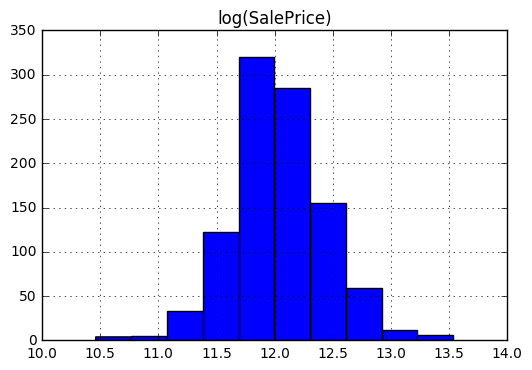

In [19]:
# Check log transform - looks good
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [20]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

(504, 42240)
(230, 42240)
(497, 42240)
(229, 42240)


#### Define model with grid search function

In [21]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


#### Function to generate submission file

In [22]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Simple function to average predictions

In [23]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)
     

#### GLM model on encoded, embedded, combined numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_297_sid_bac4_model_python_1498075739069_1_model_0   
1     [0.5]  Grid_GLM_py_297_sid_bac4_model_python_1498075739069_1_model_2   
2    [0.25]  Grid_GLM_py_297_sid_bac4_model_python_1498075739069_1_model_1   
3    [0.99]  Grid_GLM_py_297_sid_bac4_model_python_1498075739069_1_model_3   

    residual_deviance  
0  3.4027485536121755  
1   3.702060248546925  
2   3.705612847949099  
3   3.724035181349822  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_297_sid_bac4_model_python_1498075739069_1_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.005607396024280873
RMSE: 0.07488254819569692
MAE: 0.05821518945549791
RMSLE: 0.005795555871243102
R^2: 0.9641989332798108
Mean Residual Deviance: 0.005607396024280873
Null degrees of 

timestamp            duration          iteration    lambda    predictors    deviance_train         deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ---------------------  --------------------
     2017-06-21 16:31:43  0.000 sec         0            .32E2     31            0.15390841495502086    0.14821493495836877
     2017-06-21 16:31:43  0.545 sec         0            .3E2      38            0.14885316952241406    0.14353830790907543
     2017-06-21 16:31:44  1.215 sec         0            .29E2     62            0.14305698881591006    0.13823875915091802
     2017-06-21 16:31:45  1.748 sec         0            .27E2     98            0.13606140453717555    0.13195381706422638
     2017-06-21 16:31:45  2.286 sec         0            .26E2     117           0.12886476558066665    0.12552127803112412
---  ---                  ---               ---          ---       ---           ---                    ---
     2017-06-21 16:36:11  4 min 27.781 sec  0            .4E0      1706          0.0028086607035797827  0.015579798060682297
     2017-06-21 16:36:14  4 min 31.410 sec  0            .38E0     1712          0.002651058513774409   0.015679945360774595
     2017-06-21 16:37:01  5 min 17.666 sec  0            .36E0     1720          0.0025018679716883943  0.015776079438547076
     2017-06-21 16:38:41  6 min 58.044 sec  0            .35E0     1736          0.0023607161195589774  0.0158674502811091
     2017-06-21 16:39:48  8 min  5.573 sec  0            .33E0     1749          0.0022244246437843514  0.01596030138172151


See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice predict 
 
 
 11.8494 12.0772 
 12.2061 12.1815 
 11.6784 11.6256 
 11.914 11.8085 
 12.6758 12.4587 
 12.861 12.7063 
 12.1035 11.9734 
 11.2898 11.4522 
 11.7714 11.6795 
 11.5843 11.6009


glm prediction progress: |████████████████████████████████████████████████| 100%


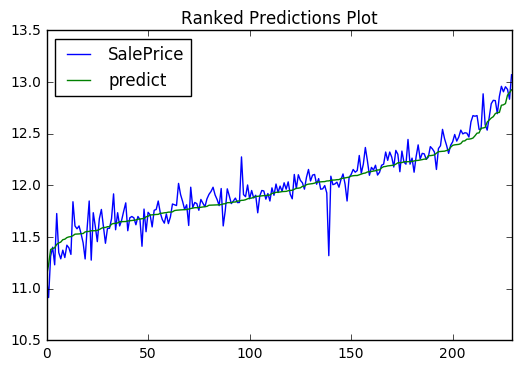

In [24]:
glm_0 = glm_grid(encoded_combined_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm_0) # Valid RMSE: ~0.1217,  0.13886 on public leaderboard

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0     [0.5]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_2   
1    [0.25]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_1   
2    [0.01]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_0   
3    [0.99]  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_3   

    residual_deviance  
0  3.2008581713135373  
1   3.249905138760205  
2   3.295060979047667  
3    3.30170051150327  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_299_sid_bac4_model_python_1498075739069_2_model_2


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.007098248526819206
RMSE: 0.08425110400949774
MAE: 0.06421357143316936
RMSLE: 0.006504969861086016
R^2: 0.9535341557548703
Mean Residual Deviance: 0.007098248526819206
Null degrees of 

timestamp            duration          iteration    lambda    predictors    deviance_train         deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ---------------------  --------------------
     2017-06-21 17:03:53  0.000 sec         0            .61E0     3             0.1448746830409686     0.17929408769788865
     2017-06-21 17:03:54  0.654 sec         0            .58E0     5             0.13666133345536333    0.16914529889115051
     2017-06-21 17:03:58  4.673 sec         0            .56E0     6             0.12810018813040555    0.15853389927611028
     2017-06-21 17:03:58  5.459 sec         0            .53E0     9             0.12001587874998602    0.14828356928536676
     2017-06-21 17:03:59  6.379 sec         0            .51E0     9             0.1125338773432392     0.1387323475395834
---  ---                  ---               ---          ---       ---           ---                    ---
     2017-06-21 17:05:12  1 min 18.872 sec  0            .77E-2    414           0.002292717795048876   0.015692793741168335
     2017-06-21 17:05:13  1 min 19.705 sec  0            .74E-2    427           0.0021513329969165785  0.01585655545490035
     2017-06-21 17:05:14  1 min 21.265 sec  0            .7E-2     446           0.002018311815117336   0.016029441330984173
     2017-06-21 17:05:16  1 min 22.842 sec  0            .67E-2    453           0.0018911756349304012  0.016206207501143186
     2017-06-21 17:05:18  1 min 24.958 sec  0            .64E-2    465           0.0017774766308707101  0.016348343215183286


See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice predict 
 
 
 11.7906 11.714 
 11.9117 11.9219 
 11.9767 11.8596 
 11.8451 11.7382 
 11.1346 11.2227 
 11.8845 11.8184 
 11.9382 11.9603 
 11.8565 11.7513 
 11.9704 11.9618 
 12.6667 12.549


glm prediction progress: |████████████████████████████████████████████████| 100%


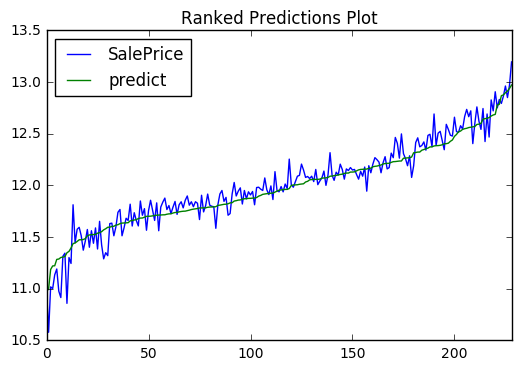

In [25]:
glm_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm_1) # Valid RMSE: ~0.1196, 0.13531 on public leaderboard

#### Blend predictions

In [26]:
# pred_blender('../data/', 
#             ['submission_Wed_Jun_21_14_36_49_2017.csv',
#              'submission_Wed_Jun_21_15_15_03_2017.csv'])
# 0.13337 on public leaderboard, better than single model!

In [27]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
